In [1]:
#pip installs
!pip3 install -q ipython-autotime
!pip3 install h5py -q

In [2]:
%reload_ext autotime
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
from itertools import islice

import gc
import h5py
from tqdm import tqdm
import librosa
import random

time: 561 µs (started: 2024-11-23 12:23:36 +00:00)


In [3]:
class SplitDataset(Dataset):
    def __init__(self, h5_file, indices):
        self.h5_file = h5_file
        self.indices = indices
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as hf:
            index = self.indices[idx]
            spectrogram = hf['spectrograms'][index] / 255.0  # Load one item and normalize
            label = hf['labels'][index]
            spectrogram = torch.tensor(spectrogram, dtype=torch.float32)
            spectrogram = spectrogram.unsqueeze(0)
            label = torch.tensor(label, dtype=torch.long)

            # Call garbage collector periodically
            if idx % 1000 == 0:
                gc.collect()
            
            return spectrogram, label

time: 1.08 ms (started: 2024-11-23 12:23:38 +00:00)


In [4]:
def create_splits(h5_path, test_split=0.1, val_split=0.2, seed=42):
    """Create dataset splits without loading entire dataset"""
    # Get dataset size without loading data
    with h5py.File(h5_path, 'r') as f:
        total_size = len(f['spectrograms'])
        labels = f['labels'][:]

    labels = labels.argmax(axis=1)
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)

    # Generate globally shuffled indices
    rng = np.random.RandomState(seed)
    all_indices = np.arange(total_size)
    rng.shuffle(all_indices)
    
    # Calculate split sizes
    test_size = int(test_split * total_size)
    val_size = int(val_split * total_size)
    train_size = total_size - test_size - val_size
    
    # Create index lists for each split
    test_indices = all_indices[:test_size]
    val_indices = all_indices[test_size:test_size + val_size]
    train_indices = all_indices[test_size + val_size:]
    
    # Create datasets using your SplitDataset class
    train_dataset = SplitDataset(h5_path, train_indices)
    val_dataset = SplitDataset(h5_path, val_indices)
    test_dataset = SplitDataset(h5_path, test_indices)
    
    return train_dataset, val_dataset, test_dataset, class_weights

time: 1.14 ms (started: 2024-11-23 12:23:39 +00:00)


In [5]:
def create_data_loaders(h5_path, batch_size=32, test_split=0.1, val_split=0.2,
                       seed=42, num_workers=4):
    """Create data loaders with memory-efficient splitting"""
    
    # Clear memory before creating splits
    gc.collect()
    torch.cuda.empty_cache()
    
    # Create datasets
    train_dataset, val_dataset, test_dataset, class_weights = create_splits(
        h5_path, test_split, val_split, seed
    )
    
    # Create data loaders with optimized settings
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=2,
        persistent_workers=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,  # No need to shuffle validation
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=2,
        persistent_workers=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,  # No need to shuffle test
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=2,
        persistent_workers=True
    )
    
    return train_loader, val_loader, test_loader, class_weights

time: 1.05 ms (started: 2024-11-23 12:23:40 +00:00)


In [6]:
DATASET_SIZE = 105526
BATCH_SIZE = 32
TEST_SPLIT = 0.1
VAL_SPLIT = 0.2
NUM_WORKERS = 4
H5_PATH = '/kaggle/input/raga-ieee-preprocessing/processed_spectrograms.h5'

train_loader, val_loader, test_loader, class_weights = create_data_loaders(
        h5_path=H5_PATH,
        batch_size=BATCH_SIZE,
        test_split=TEST_SPLIT,
        val_split=VAL_SPLIT,
        num_workers=NUM_WORKERS,
        seed=420
    )

print(f"\nDataset splits:")
print(f"Train size: {len(train_loader.dataset)}")
print(f"Val size: {len(val_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")


Dataset splits:
Train size: 73869
Val size: 21105
Test size: 10552
time: 1.61 s (started: 2024-11-23 12:23:41 +00:00)


In [ ]:
# from collections import defaultdict

# def label_distribution(dataloader):
#     label_counts = defaultdict(int)
    
#     for _, labels in dataloader:
#         # Convert one-hot encoded labels to class indices
#         label_indices = labels.argmax(dim=1)  # Get the index of the 1 in each one-hot label
        
#         for label in label_indices:
#             label_counts[label.item()] += 1
    
#     # Calculate the distribution as percentages
#     total_count = sum(label_counts.values())
#     label_distribution = {label: count / total_count * 100 for label, count in label_counts.items()}
    
#     print("Label distribution (in percentages):")
#     for label, percentage in label_distribution.items():
#         print(f"Class {label}: {percentage:.2f}% ({label_counts[label]} samples)")
    
#     return label_counts


# x = label_distribution(test_loader)
# plt.bar(x.keys(),x.values())

In [ ]:
# def plot_mel_spectrogram(mel_spectrogram, sr=16000, hop_length=512, title="Mel Spectrogram"):
#     plt.figure(figsize=(10, 4))
#     librosa.display.specshow(mel_spectrogram, 
#                              sr=sr, 
#                              hop_length=hop_length, 
#                              x_axis='time', 
#                              y_axis='mel')
#     plt.colorbar(format='%+2.0f dB')
#     plt.title(title)
#     plt.tight_layout()
#     plt.show()

In [ ]:
# # Get one random batch from the train_loader
# data_iter = iter(train_loader)
# spectrograms, labels = next(data_iter)

# # Select a random index within the batch
# random_idx = random.randint(0, spectrograms.size(0) - 1)

# # Get the spectrogram and label at that index
# spectrogram = spectrograms[random_idx].squeeze().numpy()
# label = labels[random_idx].argmax().item()  # Assuming one-hot encoded labels

# plot_mel_spectrogram(spectrogram, title=f"Mel Spectrogram for {label}")

In [ ]:
# class CNNForSpectrograms(nn.Module):
#     def __init__(self):
#         super(CNNForSpectrograms, self).__init__()
        
#         # First block
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # (256x256) -> (256x256)
#         self.pool1 = nn.MaxPool2d(2, 2)  # (256x256) -> (128x128)
#         self.dropout1 = nn.Dropout(0.2)  # Dropout after first block
        
#         # Second block
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (128x128) -> (128x128)
#         self.pool2 = nn.MaxPool2d(2, 2)  # (128x128) -> (64x64)
#         self.dropout2 = nn.Dropout(0.2)  # Dropout after second block
        
#         # Third block
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # (64x64) -> (64x64)
#         self.pool3 = nn.MaxPool2d(2, 2)  # (64x64) -> (32x32)
#         self.dropout3 = nn.Dropout(0.3)  # Dropout after third block
        
#         # Fourth block
#         self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # (32x32) -> (32x32)
#         self.pool4 = nn.MaxPool2d(2, 2)  # (32x32) -> (16x16)
#         self.dropout4 = nn.Dropout(0.3)  # Dropout after fourth block
        
#         # Final fully connected layer to reduce to a 16x16 feature space
#         self.fc = nn.Linear(256 * 16 * 16, 1024)  # Flattened 16x16x256 -> 1024
#         self.dropout_fc = nn.Dropout(0.4)  # Dropout before final output
        
#         # Output layer (for classification)
#         self.output = nn.Linear(1024, 10)  # For 10 thaat classes

#     def forward(self, x):
#         # Forward pass through convolutional blocks
#         x = F.relu(self.conv1(x))
#         x = self.pool1(x)
#         x = self.dropout1(x)  # Apply dropout
        
#         x = F.relu(self.conv2(x))
#         x = self.pool2(x)
#         x = self.dropout2(x)  # Apply dropout
        
#         x = F.relu(self.conv3(x))
#         x = self.pool3(x)
#         x = self.dropout3(x)  # Apply dropout
        
#         x = F.relu(self.conv4(x))
#         x = self.pool4(x)
#         x = self.dropout4(x)  # Apply dropout
        
#         # Flatten the output from convolutional layers
#         x = x.view(x.size(0), -1)  # Flatten: batch_size x (256*16*16)
        
#         # Fully connected layer with dropout
#         x = F.relu(self.fc(x))
#         x = self.dropout_fc(x)  # Apply dropout
        
#         # Output layer for classification
#         x = self.output(x)
        
#         return x

In [7]:
class CNN_with_BottleNeck(nn.Module):
    def __init__(self):
        super(CNN_with_BottleNeck, self).__init__()
        
        # Feature extraction blocks
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # (256x256) -> (128x128)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # (128x128) -> (64x64)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # (64x64) -> (32x32)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)  # (32x32) -> (16x16)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Additional convolutional block for better feature extraction
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2)  # (16x16) -> (8x8)
        self.bn5 = nn.BatchNorm2d(512)
        
        # Bottleneck: Progressive channel reduction
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(128, 1, kernel_size=1)
        )
        
        # Global average pooling for spatial reduction
        self.global_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # Classification head
        self.fc = nn.Linear(1 * 4 * 4, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool5(x)
        
        x = self.bottleneck(x)  # Shape: (batch_size, 1, 8, 8)
        x = self.global_pool(x)  # Shape: (batch_size, 1, 4, 4)
        
        x = x.view(x.size(0), -1)  # Flatten: (batch_size, 16)
        x = self.fc(x)  # Shape: (batch_size, 10)
        
        return x

time: 2.29 ms (started: 2024-11-23 12:23:51 +00:00)


In [8]:
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_labels = []
    
    # Create progress bar for validation
    val_pbar = tqdm(val_loader, desc='Validation')
    
    with torch.no_grad():
        for spectrograms, labels in val_pbar:
            spectrograms = spectrograms.to(device)
            labels = torch.argmax(labels, dim=1).to(device).long()
            
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_predictions.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            
            val_pbar.set_postfix({'loss': loss.item()})
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_predictions)
    
    return val_loss, val_accuracy

time: 1.03 ms (started: 2024-11-23 12:23:59 +00:00)


In [9]:
def test_model(model, test_loader, device):
    model.eval()
    test_predictions = []
    test_labels = []
    
    # Create progress bar for testing
    test_pbar = tqdm(test_loader, desc='Testing')
    
    with torch.no_grad():
        for spectrograms, labels in test_pbar:
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)
            
            outputs = model(spectrograms)
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class indices
            
            test_predictions.extend(predicted.cpu().numpy())  # Convert to numpy array of class indices
            test_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())  # Convert one-hot to class indices
    
    # Convert to numpy arrays for consistency
    test_predictions = np.array(test_predictions)
    test_labels = np.array(test_labels)
    
    # Calculate metrics
    accuracy = accuracy_score(test_labels, test_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='weighted')
    
    print("\nTest Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return accuracy, precision, recall, f1

time: 1.26 ms (started: 2024-11-23 12:24:01 +00:00)


In [10]:
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 4))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

time: 835 µs (started: 2024-11-23 12:24:03 +00:00)


In [11]:
def train_model(model, train_loader, val_loader, num_epochs, class_weights, device='cuda'):
    # Initialize model, loss, and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    # Initialize lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_predictions = []
        train_labels = []
        
        # Create progress bar for training
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        
        for spectrograms, labels in train_pbar:
            # Move data to device
            spectrograms = spectrograms.to(device)
            labels = torch.argmax(labels, dim=1).to(device).long()
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update metrics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_predictions.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            train_pbar.set_postfix({'loss': loss.item()})
        
        # Calculate epoch metrics
        train_loss = train_loss / len(train_loader)
        train_accuracy = accuracy_score(train_labels, train_predictions)
        
        # Validation phase
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            # Save best model
            # torch.save({
            #     'epoch': epoch,
            #     'model_state_dict': model.state_dict(),
            #     'optimizer_state_dict': optimizer.state_dict(),
            #     'val_loss': val_loss,
            # }, 'best_model_4x4_2.pth')
            # Save best model along with training metrics
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),  # Save LR scheduler state
                'train_losses': train_losses,  # Training losses for all epochs
                'val_losses': val_losses,      # Validation losses for all epochs
                'train_accuracies': train_accuracies,  # Training accuracies for all epochs
                'val_accuracies': val_accuracies,      # Validation accuracies for all epochs
                'val_loss': val_loss,  # Best validation loss
            }, 'best_model_4x4_with_metrics.pth')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= 5:  # Early stopping patience
                print(f'\nEarly stopping triggered after {epoch+1} epochs')
                break
        
        # Print epoch metrics
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        torch.cuda.empty_cache()
    
    return train_losses, val_losses, train_accuracies, val_accuracies

time: 3.89 ms (started: 2024-11-23 12:24:05 +00:00)


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = RagaFeatureExtractorCNN(input_channels=1, num_classes=10).to(device)
model = CNN_with_BottleNeck().to(device)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

print(model)

Using 2 GPUs!
DataParallel(
  (module): CNN_with_BottleNeck(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [13]:
history = train_model(model, 
                      train_loader,
                      val_loader,
                      num_epochs=25,
                      class_weights=class_weights.to(device),
                      device=device)

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/25 [Train]:   0%|          | 0/2309 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation:   0%|          | 0/660 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation: 100%|██████████| 660/660 [01:52<00:00,  5.85it/s, loss=1.8] 



Epoch 1/25:
Train Loss: 1.9710, Train Accuracy: 0.2546
Val Loss: 1.7211, Val Accuracy: 0.3589


Epoch 2/25 [Train]:   0%|          | 0/2309 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation:   0%|          | 0/660 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation: 100%|██████████| 660/660 [01:52<00:00,  5.88it/s, loss=0.87] 



Epoch 2/25:
Train Loss: 1.0135, Train Accuracy: 0.6270
Val Loss: 0.8731, Val Accuracy: 0.6837


Epoch 3/25 [Train]:   0%|          | 0/2309 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation:   0%|          | 0/660 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation: 100%|██████████| 660/660 [01:50<00:00,  5.95it/s, loss=1.25] 



Epoch 3/25:
Train Loss: 0.6128, Train Accuracy: 0.7829
Val Loss: 0.6761, Val Accuracy: 0.7692


Epoch 4/25 [Train]:   0%|          | 0/2309 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation:   0%|          | 0/660 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation: 100%|██████████| 660/660 [01:53<00:00,  5.81it/s, loss=1.24] 



Epoch 4/25:
Train Loss: 0.4240, Train Accuracy: 0.8487
Val Loss: 0.5981, Val Accuracy: 0.7904


Epoch 5/25 [Train]:   0%|          | 0/2309 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation:   0%|          | 0/660 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation: 100%|██████████| 660/660 [01:47<00:00,  6.13it/s, loss=0.35] 



Epoch 5/25:
Train Loss: 0.3146, Train Accuracy: 0.8876
Val Loss: 0.6472, Val Accuracy: 0.7897


Epoch 6/25 [Train]:   0%|          | 0/2309 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation:   0%|          | 0/660 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation: 100%|██████████| 660/660 [01:50<00:00,  5.95it/s, loss=0.92]  



Epoch 6/25:
Train Loss: 0.2422, Train Accuracy: 0.9131
Val Loss: 0.5561, Val Accuracy: 0.8352


Epoch 7/25 [Train]:   0%|          | 0/2309 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation:   0%|          | 0/660 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation: 100%|██████████| 660/660 [01:51<00:00,  5.92it/s, loss=0.691] 



Epoch 7/25:
Train Loss: 0.1979, Train Accuracy: 0.9282
Val Loss: 0.4879, Val Accuracy: 0.8416


Epoch 8/25 [Train]:   0%|          | 0/2309 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation:   0%|          | 0/660 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation: 100%|██████████| 660/660 [02:10<00:00,  5.07it/s, loss=0.522] 



Epoch 8/25:
Train Loss: 0.1613, Train Accuracy: 0.9427
Val Loss: 0.4982, Val Accuracy: 0.8450


Epoch 9/25 [Train]:   0%|          | 0/2309 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation:   0%|          | 0/660 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation: 100%|██████████| 660/660 [01:50<00:00,  5.97it/s, loss=0.423] 



Epoch 9/25:
Train Loss: 0.1411, Train Accuracy: 0.9493
Val Loss: 0.4950, Val Accuracy: 0.8417


Epoch 10/25 [Train]:   0%|          | 0/2309 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation:   0%|          | 0/660 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation: 100%|██████████| 660/660 [01:52<00:00,  5.86it/s, loss=0.38]  



Epoch 10/25:
Train Loss: 0.1212, Train Accuracy: 0.9568
Val Loss: 0.3846, Val Accuracy: 0.8909


Epoch 11/25 [Train]:   0%|          | 0/2309 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation:   0%|          | 0/660 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation: 100%|██████████| 660/660 [01:51<00:00,  5.91it/s, loss=0.608] 



Epoch 11/25:
Train Loss: 0.1070, Train Accuracy: 0.9621
Val Loss: 0.6044, Val Accuracy: 0.8567


Epoch 12/25 [Train]:   0%|          | 0/2309 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation:   0%|          | 0/660 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation: 100%|██████████| 660/660 [01:48<00:00,  6.08it/s, loss=0.817]  



Epoch 12/25:
Train Loss: 0.0944, Train Accuracy: 0.9660
Val Loss: 0.4387, Val Accuracy: 0.8907


Epoch 13/25 [Train]:   0%|          | 0/2309 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation:   0%|          | 0/660 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation: 100%|██████████| 660/660 [01:49<00:00,  6.03it/s, loss=1.29]  



Epoch 13/25:
Train Loss: 0.0874, Train Accuracy: 0.9692
Val Loss: 0.5828, Val Accuracy: 0.8583


Epoch 14/25 [Train]:   0%|          | 0/2309 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Epoch 14/25 [Train]:  25%|██▌       | 583/2309 [01:39<04:13,  6.80it/s, loss=0.0303]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validation:   0%|          | 0/660 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('


Epoch 14/25:
Train Loss: 0.0778, Train Accuracy: 0.9723
Val Loss: 0.4571, Val Accuracy: 0.8855


Epoch 15/25 [Train]:   0%|          | 0/2309 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation:   0%|          | 0/660 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation: 100%|██████████| 660/660 [01:56<00:00,  5.67it/s, loss=0.406]  


Early stopping triggered after 15 epochs
time: 2h 8min 21s (started: 2024-11-23 12:24:09 +00:00)


In [ ]:
checkpoint = torch.load('best_model.pth', weights_only=True)
history = model.load_state_dict(checkpoint['model_state_dict'])

val_losses = checkpoint['val_loss']

model.eval()

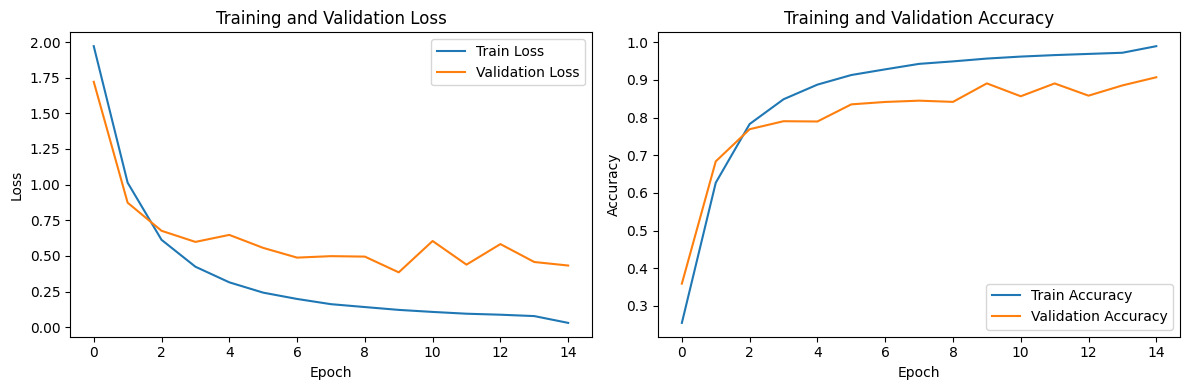

time: 574 ms (started: 2024-11-23 14:38:37 +00:00)


In [14]:
plot_training_history(*history)

In [15]:
test_metrics = test_model(model, test_loader, device)

Testing:   0%|          | 0/330 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Testing: 100%|██████████| 330/330 [01:16<00:00,  4.32it/s]


Test Results:
Accuracy: 0.9014
Precision: 0.9031
Recall: 0.9014
F1 Score: 0.9016
time: 1min 16s (started: 2024-11-23 14:38:44 +00:00)
